In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as pt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [4]:
class GradientBooster:
    
    def __init__(self, max_depth=8, min_samples_split=5, min_samples_leaf=5, max_features=3, lr=0.1, num_iter=3000):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.lr = lr
        self.num_iter = num_iter
        self.y_mean = 0
        
    def __calculate_loss(self,y, y_pred):
        loss = (1/len(y)) * 0.5 * np.sum(np.square(y-y_pred))
        return loss
    
    def __take_gradient(self, y, y_pred):
        grad = -(y-y_pred)
        return grad
    
    def __create_base_model(self, X, y):
        base = DecisionTreeRegressor(criterion='squared_error',max_depth=self.max_depth,
                                    min_samples_split=self.min_samples_split,
                                    min_samples_leaf=self.min_samples_leaf,
                                    max_features=self.max_features)
        base.fit(X,y)
        return base
    
    def predict(self,models,X):
        pred_0 = np.array([self.y_mean] * len(X))
        pred = pred_0.reshape(len(pred_0),1)
        
        for i in range(len(models)):
            temp = (models[i].predict(X)).reshape(len(X),1)
            pred -= self.lr * temp
        
        return pred
    
    def train(self, X, y):
        models = []
        losses = []
        self.y_mean = np.mean(y)
        pred_0 = np.array([np.mean(y)] * len(y))
        pred = pred_0.reshape(len(pred_0),1)
        
        for epoch in range(self.num_iter):
            loss = self.__calculate_loss(y, pred)
            losses.append(loss)
            grads = self.__take_gradient(y, pred)
            base = self.__create_base_model(X, grads)
            r = (base.predict(X)).reshape(len(X),1)
            pred -= self.lr * r
            models.append(base)
            
        return models, losses, pred_0

In [5]:
df = pd.read_csv("cleaned_shifted_data.csv")

In [6]:
df.head()

,Timestamp,Unnamed: 0,Station,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),Checks,AQI_calculated,AQI_bucket_calculated,AQI_calculated_shifted,AQI_bucket_calculated_shifted
0,2019-02-17 15:15:00,4573,Railway Colony,46.00,80.00,1.29,9.16,12.02,27.19,13.56,0.40,15.80,7,67.0,Satisfactory,296.0,Poor
1,2019-02-17 15:30:00,4574,Railway Colony,46.00,80.00,1.74,8.93,12.48,30.29,13.71,0.41,15.52,7,68.0,Satisfactory,297.0,Poor
2,2019-02-17 15:45:00,4575,Railway Colony,45.62,79.92,1.87,8.56,12.17,28.20,13.88,0.41,15.33,7,68.0,Satisfactory,298.0,Poor
3,2019-02-17 16:00:00,4576,Railway Colony,41.00,72.92,1.83,8.72,12.37,26.69,13.77,0.40,15.30,7,68.0,Satisfactory,298.0,Poor
4,2019-02-17 16:15:00,4577,Railway Colony,41.00,79.00,1.69,7.91,11.30,26.83,13.87,0.41,15.49,7,68.0,Satisfactory,299.0,Poor


In [8]:
from sklearn.preprocessing import OneHotEncoder
oe = OneHotEncoder(sparse_output=False)
encoded = oe.fit_transform(pd.DataFrame(df['Station']))
one_hot_df = pd.DataFrame(encoded, columns=oe.get_feature_names_out(['Station']))
df = pd.concat([df, one_hot_df], axis=1)

In [9]:
df.columns

Index(['Timestamp', 'Unnamed: 0', 'Station', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)',
       'NO (µg/m³)', 'NO2 (µg/m³)', 'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)',
       'CO (mg/m³)', 'Ozone (µg/m³)', 'Checks', 'AQI_calculated',
       'AQI_bucket_calculated', 'AQI_calculated_shifted',
       'AQI_bucket_calculated_shifted', 'Station_IITG ',
       'Station_LGBI Airport ', 'Station_Pan Bazaar ',
       'Station_Railway Colony '],
      dtype='object')

In [10]:
drop_cols = [0,1,2,12,14,16]
drop_cols = df.columns[drop_cols]
drop_cols

Index(['Timestamp', 'Unnamed: 0', 'Station', 'Checks', 'AQI_bucket_calculated',
       'AQI_bucket_calculated_shifted'],
      dtype='object')

In [11]:
df.drop(drop_cols,axis=1,inplace=True)

In [12]:
X = df.drop('AQI_calculated_shifted',axis = 1)
y = df['AQI_calculated_shifted']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
#scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = np.array(y_train).reshape(X_train.shape[0],1)
y_test = np.array(y_test).reshape(X_test.shape[0],1)
#TRAIN
G = GradientBooster()
models, losses, pred_0 = G.train(X_train,y_train)

KeyboardInterrupt: 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Loss vs Epoch')]

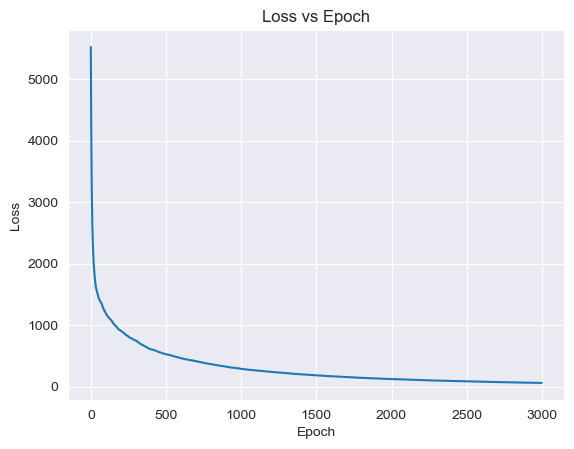

In [61]:
sns.set_style('darkgrid')
ax = sns.lineplot(x=range(3000),y=losses)
ax.set(xlabel='Epoch',ylabel='Loss',title='Loss vs Epoch')

In [64]:
y_pred = G.predict(models, X_test)
print('MSE:',(mean_squared_error(y_test,y_pred)))

MSE: 1490.5114505217568


In [88]:
from sklearn.svm import SVR
svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X_train, y_train)

d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(epsilon=0.2)

In [ ]:
y_pred = svr.predict(models, X_test)
print('MSE:',(mean_squared_error(y_test,y_pred)))

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
from sklearn.linear_model import Lasso,Ridge
ls = Lasso(alpha=0.01)

In [26]:
ls.fit(X_train,y_train)

d:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.428e+05, tolerance: 1.544e+05
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.01)

In [27]:
mean_squared_error(ls.predict(X_test),y_test)

6449.711479509628

In [30]:
rs = Ridge(alpha=0.1)
rs.fit(X_train,y_train)

Ridge(alpha=0.1)

In [31]:
mean_squared_error(rs.predict(X_test),y_test)

6449.69714628992